In [ ]:
#Label the data
import pandas as pd
import numpy as np

y= pd.read_csv("/content/Labels.csv")
#Volatility
y['log_returns'] = y['Close'].rolling(window=2).apply(lambda x: np.log(x.iloc[1]/x.iloc[0]))
y['variance'] = y['log_returns'].rolling(window=10).var() # ==> Variance calculation 
y['variance'].fillna(0, inplace=True)
# Direction of the market
y['market_direction'] = y['Close'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] >= x.iloc[0] else 0)
y['vol_direction'] = y['Close'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] >= x.iloc[0] else 0)
 
y['market_direction'].fillna(0, inplace=True)
y['vol_direction'].fillna(0, inplace=True)
# Labelling
y_Volatility = y.reset_index()['variance'] *1000
y_Direction = y.reset_index()['market_direction']
y_vol_Direction = y.reset_index()['vol_direction']

In [ ]:
# Text data pre-processing
import nltk 
from nltk.corpus import stopwords
from nltk import stem
nltk.download('stopwords')

news_data =pd.read_csv("/content/Combined_News_DJIA.csv")
x= news_data.drop(['Label','Date'], axis=1)
x.columns = [str(c) for c in range(25)]

for i in x.columns:
    df = x[i].str.strip()     
    df = df.str.replace(' ', '_')   
    df= df.str.replace(r'b\'', '')
    df= df.str.replace(r'b\"', '')    
    df = df.str.replace(r"[^0-9a-zA-Z\_]+", "")
    df = df.str.replace('_+', ' ')  
    x[i]= df.str.lower()

x["combined_news"] = x.apply(lambda x: ''.join(str(x.values)), axis=1)
stopwords = nltk.corpus.stopwords.words('english')
ps = stem.PorterStemmer()

def clean_stem_stopWords(line: str ):
  return ' '.join(ps.stem(word) for word in line.split() if not word in stopwords)
x["combined_news"] = x["combined_news"].apply(lambda x: clean_stem_stopWords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1989


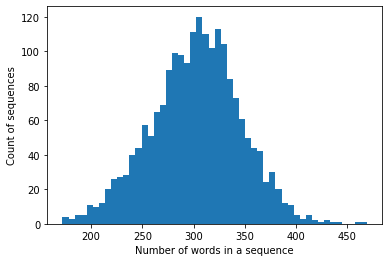

In [ ]:
# Print the distribution of the sequence lengths
seq_len = [len(i.split()) for i in x["combined_news"]]
from matplotlib import pyplot as plt
print(len(seq_len))
plt.hist(pd.Series(seq_len),bins = 50)
plt.xlabel("Number of words in a sequence")
plt.ylabel("Count of sequences")

plt.show()

In [ ]:
# simple tokenizer and padding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 350
MAX_NUM_WORDS = 10000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x["combined_news"])
data = tokenizer.texts_to_sequences(x["combined_news"])
data = pad_sequences(data, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(data.shape)

(1989, 350)


In [ ]:
data[0].shape

(350,)

In [ ]:
# BOW
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 10000 # number of features

countvector=CountVectorizer(ngram_range=(2,2), stop_words='english',max_features=MAX_NUM_WORDS)
traindataset=countvector.fit_transform(x["combined_news"])

print(traindataset.shape)


(1989, 10000)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scaler
sc_X = StandardScaler()
X = sc_X.fit_transform(traindataset.toarray())

# PCA
pca=PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [ ]:
# choose right objective
y= y_vol_Direction

# Splitting the data:
num_validation_samples = 100
x_train = X_pca[:-num_validation_samples]
x_val = X_pca[-num_validation_samples:]
y_train = y[:-num_validation_samples]
y_val = y[-num_validation_samples:]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from matplotlib import pyplot as plt
from sklearn.svm import SVC

# select the model
#model= LogisticRegression()
model = SVC(kernel='rbf', max_iter=150)
#model = RandomForestClassifier(n_estimators=200,criterion='entropy')

#Cross validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#Show box plot of K-fold validation accuracy

print("mean accuracy:", np.mean(scores))
print("standard error:", np.std(scores))

#plt.boxplot(scores)

mean accuracy: 0.5314019592914064
standard error: 0.032324948517269185


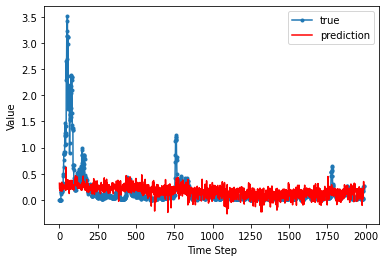

In [ ]:
# Compare Prediction results on train + validation data
plt.plot( y , marker='.', label="true")
plt.plot( np.append(y_train_pred,y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.legend()
plt.show();

In [ ]:
# MLP
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout

def train_predict_MLP_model(x_train, y_train):


  input_shape = ( 50,)

  # Create the model
  model = Sequential()
  model.add(Dense(50, input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,  activation='relu'))
  model.add(Dropout(0.2))

  # binary_crossentropy and sigmoid activation function for classification problem.
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)
  return model


In [ ]:
from sklearn.metrics import accuracy_score

trains = []
tests = []
cv = KFold(n_splits=6, shuffle=False)
for train_index, test_index in cv.split(X_pca):
    X_train, X_test, y_train, y_test = np.array(X_pca)[train_index], np.array(X_pca)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    
    model = train_predict_MLP_model(X_train, y_train)
    #loss1, accuracy1 = model.evaluate(X_train, y_train)
    loss2, accuracy2 = model.evaluate(X_test, y_test)
    #print(model.metrics_names, accuracy1)
    #print(model.metrics_names, accuracy2)
    #trains.append(accuracy1) # add  squared=True for RMSE
    tests.append(accuracy2)

#print(" TRAIN mean score with std error:", np.mean(trains), np.std(trains))
print(" TEST mean score with std error:", np.mean(tests), np.std(tests))

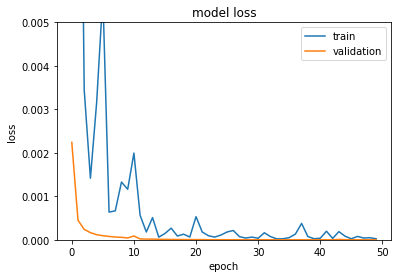

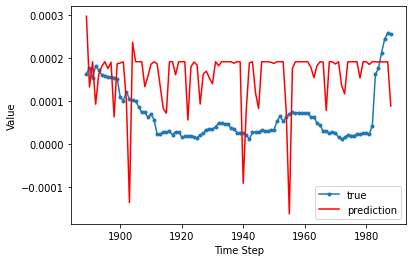

In [ ]:
# Results with simple MLP... if CV last model is saved
y_pred= model.predict(x_val)

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,0.005)
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Price_MLP_val_2.png')
plt.show()

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

In [ ]:
# Convert the data shape into 3-Dimensional for LSTM

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)
x_train.shape

In [ ]:
#LSTM

from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout, LSTM
from sklearn.metrics import accuracy_score

def train_predict_LSTM_model(x_train, y_train ):

  
  input_shape = ( 50,1)

  # Create the model
  model = Sequential()
  model.add(LSTM(30, dropout=0.15, activation ='relu', input_shape=input_shape))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

  #Results with LSTM
  return model


trains = []
tests = []
cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(X_pca):
    X_train, X_test, y_train, y_test = np.array(X_pca)[train_index], np.array(X_pca)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    #reshape for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test =X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    #Get the trained model
    model = train_predict_LSTM_model(X_train, y_train)
    #loss1, accuracy1 = model.evaluate(X_train, y_train)
    loss2, accuracy2 = model.evaluate(X_test, y_test)
    #print(model.metrics_names, accuracy1)
    #print(model.metrics_names, accuracy2)
    #trains.append(accuracy1) # add  squared=True for RMSE
    tests.append(accuracy2)

#print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))
print(" TEST mean score with std error:", np.mean(tests), np.var(tests))

Epoch 1/20
128/128 [==============================] - 3s 20ms/step - loss: 0.6903 - accuracy: 0.5299 - val_loss: 0.6976 - val_accuracy: 0.5141
Epoch 2/20
128/128 [==============================] - 3s 25ms/step - loss: 0.6899 - accuracy: 0.5369 - val_loss: 0.7010 - val_accuracy: 0.5141
Epoch 3/20
128/128 [==============================] - 4s 28ms/step - loss: 0.6873 - accuracy: 0.5472 - val_loss: 0.7026 - val_accuracy: 0.5141
Epoch 4/20
128/128 [==============================] - 3s 20ms/step - loss: 0.6886 - accuracy: 0.5338 - val_loss: 0.7097 - val_accuracy: 0.5172
Epoch 5/20
128/128 [==============================] - 3s 20ms/step - loss: 0.6912 - accuracy: 0.5401 - val_loss: 0.6995 - val_accuracy: 0.5172
Epoch 6/20
128/128 [==============================] - 3s 26ms/step - loss: 0.6883 - accuracy: 0.5472 - val_loss: 0.6961 - val_accuracy: 0.5235
Epoch 7/20
128/128 [==============================] - 3s 26ms/step - loss: 0.6889 - accuracy: 0.5440 - val_loss: 0.6993 - val_accuracy: 0.5172